## Forecasts for Product Demand
### Dataset
- https://www.kaggle.com/datasets/felixzhao/productdemandforecasting?resource=download
- The dataset contains historical product demand for a manufacturing company with footprints globally. 
- The company provides thousands of products within dozens of product categories. 
- There are four central warehouses to ship products within the region it is responsible for. 
- Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. 
- If forecasts for each product in different central with reasonable accuracy for the **monthly demand for month after next** can be achieved, it would be beneficial to the company in multiple ways.

In [1]:
import logging
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

sns.set_style('darkgrid')
sns.set_palette("bright")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
class OrderPredictByCenter():
    
    # 상속받을거? after 별도 클래스
    def __init__(self):
        
        self.file_path = "data/Historical Product Demand.csv"        
        self.start_date = '2012-01-01'
        self.end_date = '2016-12'
        self.opt_param = False # True 경우 파라메터 최적화 진행
        self.param_space = {
                            'learning_rate': [0.01, 0.05, 0.1],
                            'n_estimators': [100, 200, 300],
                            'max_depth': [3, 5, 10],
                            'num_leaves': [20, 30, 40],
                            'min_child_samples': [1, 5, 10],
                            'subsample': [0.5, 0.7, 0.9],
                            'colsample_bytree': [0.5, 0.7, 0.9]
                            }        

        
    @staticmethod
    def _check_if_numeric(value):
        """
        값이 만약 수치형이면 True, 아니면 에러대신 False 반환
        """
        try:
            pd.to_numeric(value)
            return True
        except (TypeError, ValueError):
            return False


    def load_data(self):

        """
        데이터 불러와서 타깃의 값이 수치형 아닌 경우 제거
        """
        df = pd.read_csv(self.file_path) # local path
        df.columns = ['prd_code', 'warehouse', 'category', 'date', 'order']

        # 수치형이 아닌 경우 제거
        df['is_num'] = df.order.apply(self._check_if_numeric)
        df = df.query("is_num == True").drop('is_num', axis=1)

        # datetime, int 형태로 컬럼 타입을 변환
        df['date'] = pd.to_datetime(df['date'])
        #df.rename(columns={'date':'date_day'}, inplace=True)
        
        # monthly prediction을 위해 YYYY-MM 형태로 변환
        #df['date_month'] = pd.to_datetime(df['date_day'].dt.strftime('%Y-%m'))
        df['order'] = df['order'].astype(int)    
        logging.info("load the dataset is finished")
        return df            

    
    def features(self): pass
    def fit_train(self): pass

    
    def preprocess(self):        
        """
        전처리 함수 처리
        """
        logging.info("postrocess is finished")
        
        df = self.load_data()  
        df = df.query("date >= '2012-01-01' and date <= '2016-12'")
        
        # aggregation
        df1 = df.groupby(["warehouse", "date"])['order'].sum().reset_index()
                        
        logging.info("preprocess is finished")
        return df1
    
#     def postprocess(self):
#         return df    

In [3]:
self = OrderPredictByCenter()

In [4]:
df = self.preprocess()

In [5]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofweek

In [6]:
df = df.set_index("date")

In [7]:
df

,warehouse,order,month,day
date,,,,
2012-01-02,Whse_A,500,1,0
2012-01-03,Whse_A,152892,1,1
2012-01-04,Whse_A,69163,1,2
2012-01-05,Whse_A,38834,1,3
2012-01-06,Whse_A,103533,1,4
...,...,...,...,...
2016-11-27,Whse_S,890001,11,6
2016-11-28,Whse_S,588184,11,0
2016-11-29,Whse_S,850367,11,1


In [8]:
target_encoder = ce.TargetEncoder(cols=['warehouse'])

In [9]:
end_date = '2016-01-01'

In [45]:
train = df[df.index < end_date]
pred = df[df.index >= end_date]

In [46]:
train['warehouse'] = target_encoder.fit_transform(train['warehouse'], train['order'])

In [47]:
X_train = train.drop("order", axis=1)
y_train = train[['order']]

In [48]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()

In [49]:
model.fit(X_train, y_train)        

LGBMRegressor()

In [50]:
X_pred = pred.drop("order", axis=1)
X_pred['warehouse'] = target_encoder.transform(X_pred['warehouse'])

y_pred = pred[['warehouse','order']]

In [51]:
y_pred['pred_cnt'] = model.predict(X_pred).astype(int)

In [52]:
y_pred

,warehouse,order,pred_cnt
date,,,
2016-01-03,Whse_A,5339,18890
2016-01-04,Whse_A,45441,75490
2016-01-05,Whse_A,85075,121020
2016-01-06,Whse_A,127765,100207
2016-01-07,Whse_A,47509,100006
...,...,...,...
2016-11-27,Whse_S,890001,697813
2016-11-28,Whse_S,588184,693193
2016-11-29,Whse_S,850367,1084045


In [57]:
y_pred.warehouse.value_counts()

Whse_A    268
Whse_S    256
Whse_C    251
Whse_J    250
Name: warehouse, dtype: int64

In [ ]:
y_pred['ape'] = 1-(abs(y_pred['pred_cnt'] - y_pred['order'])/y_pred['order'])

In [64]:
y_pred.groupby("warehouse").ape.median()

warehouse
Whse_A    0.568784
Whse_C    0.439481
Whse_J    0.786945
Whse_S   -0.678333
Name: ape, dtype: float64

<Axes: xlabel='date'>

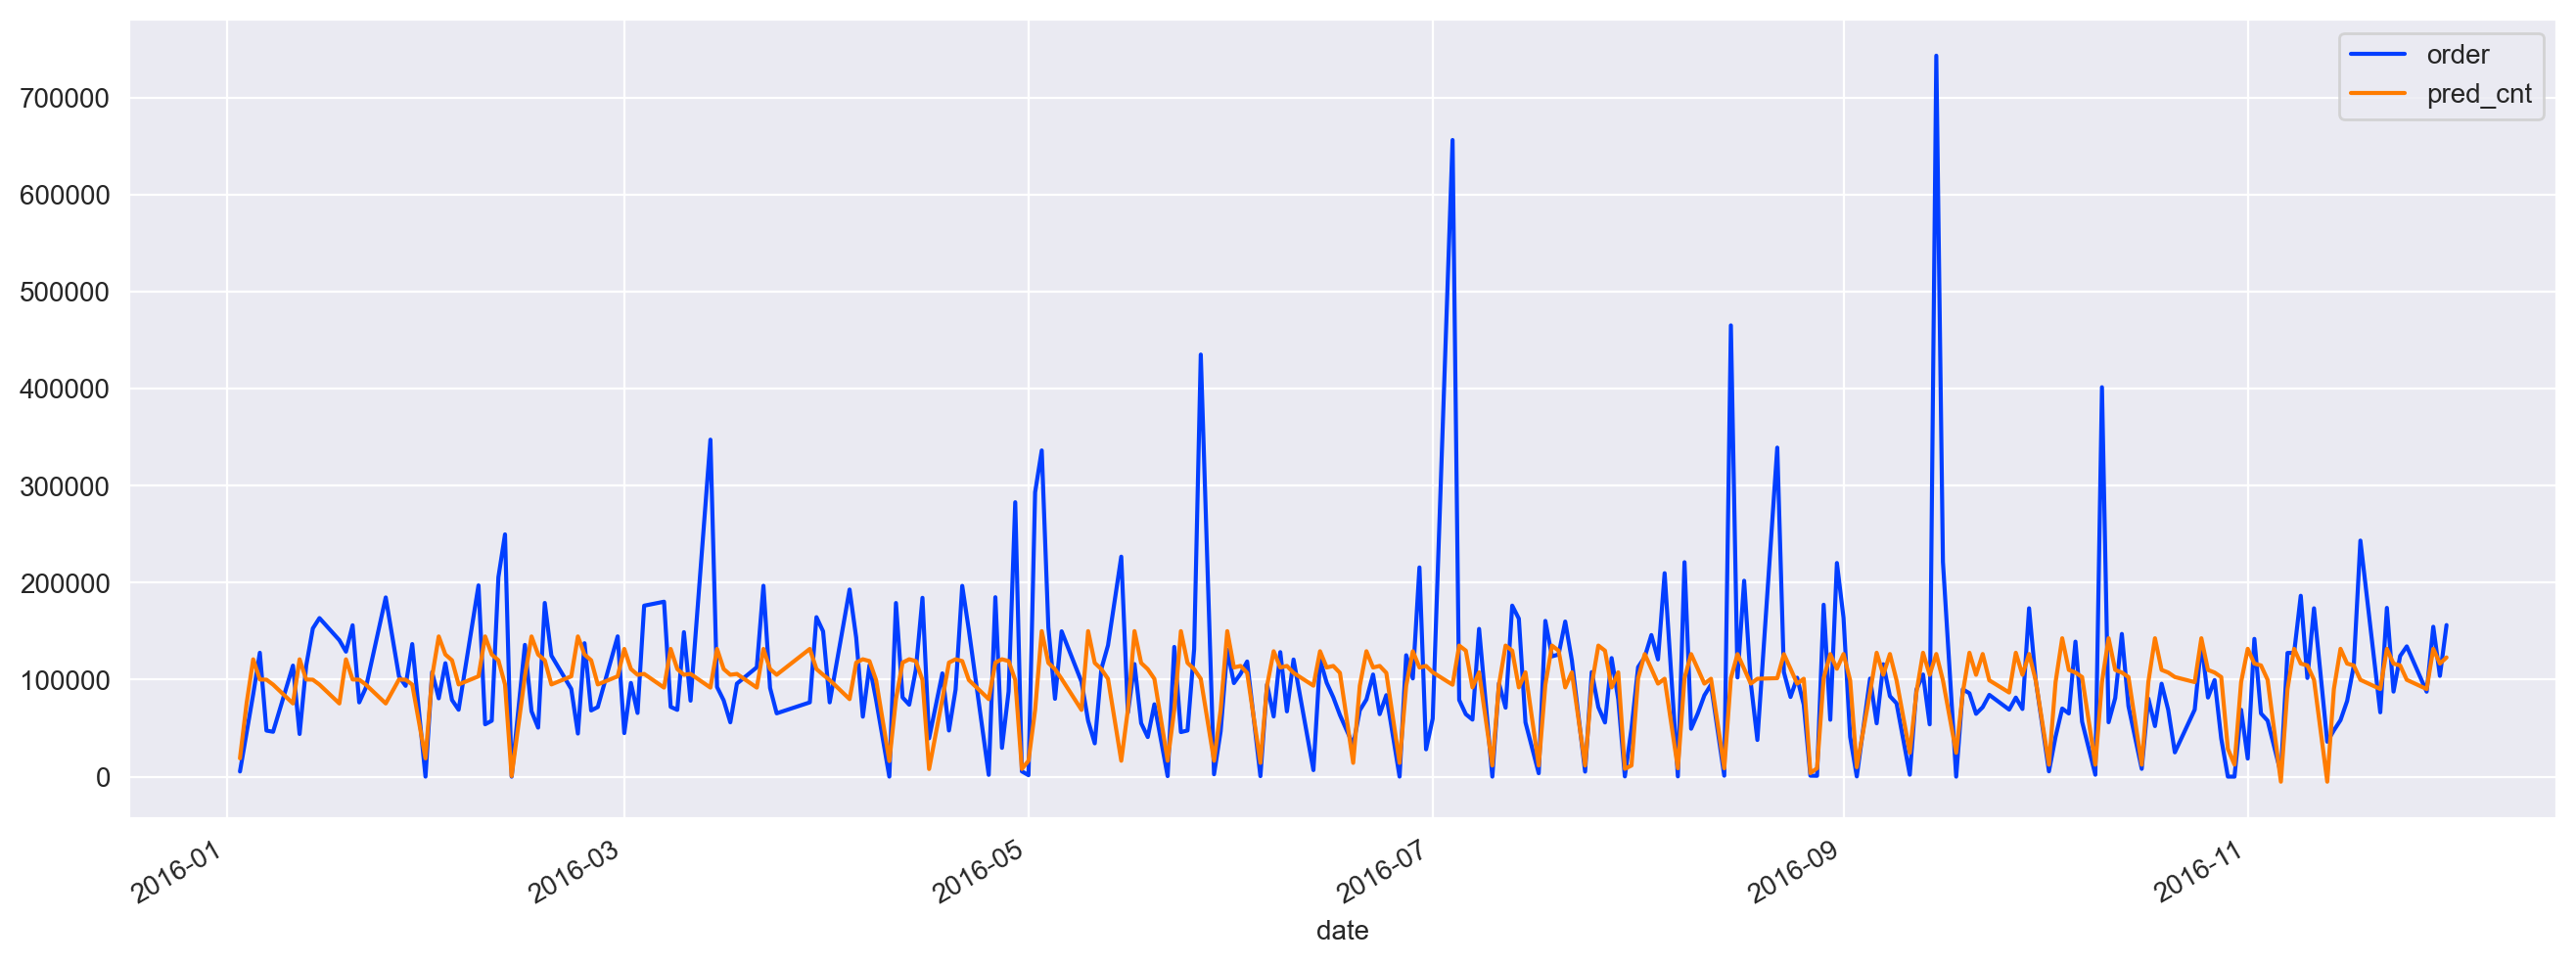

In [54]:
y_pred.query("warehouse == 'Whse_A'").plot(figsize=(16,6))

<Axes: xlabel='date'>

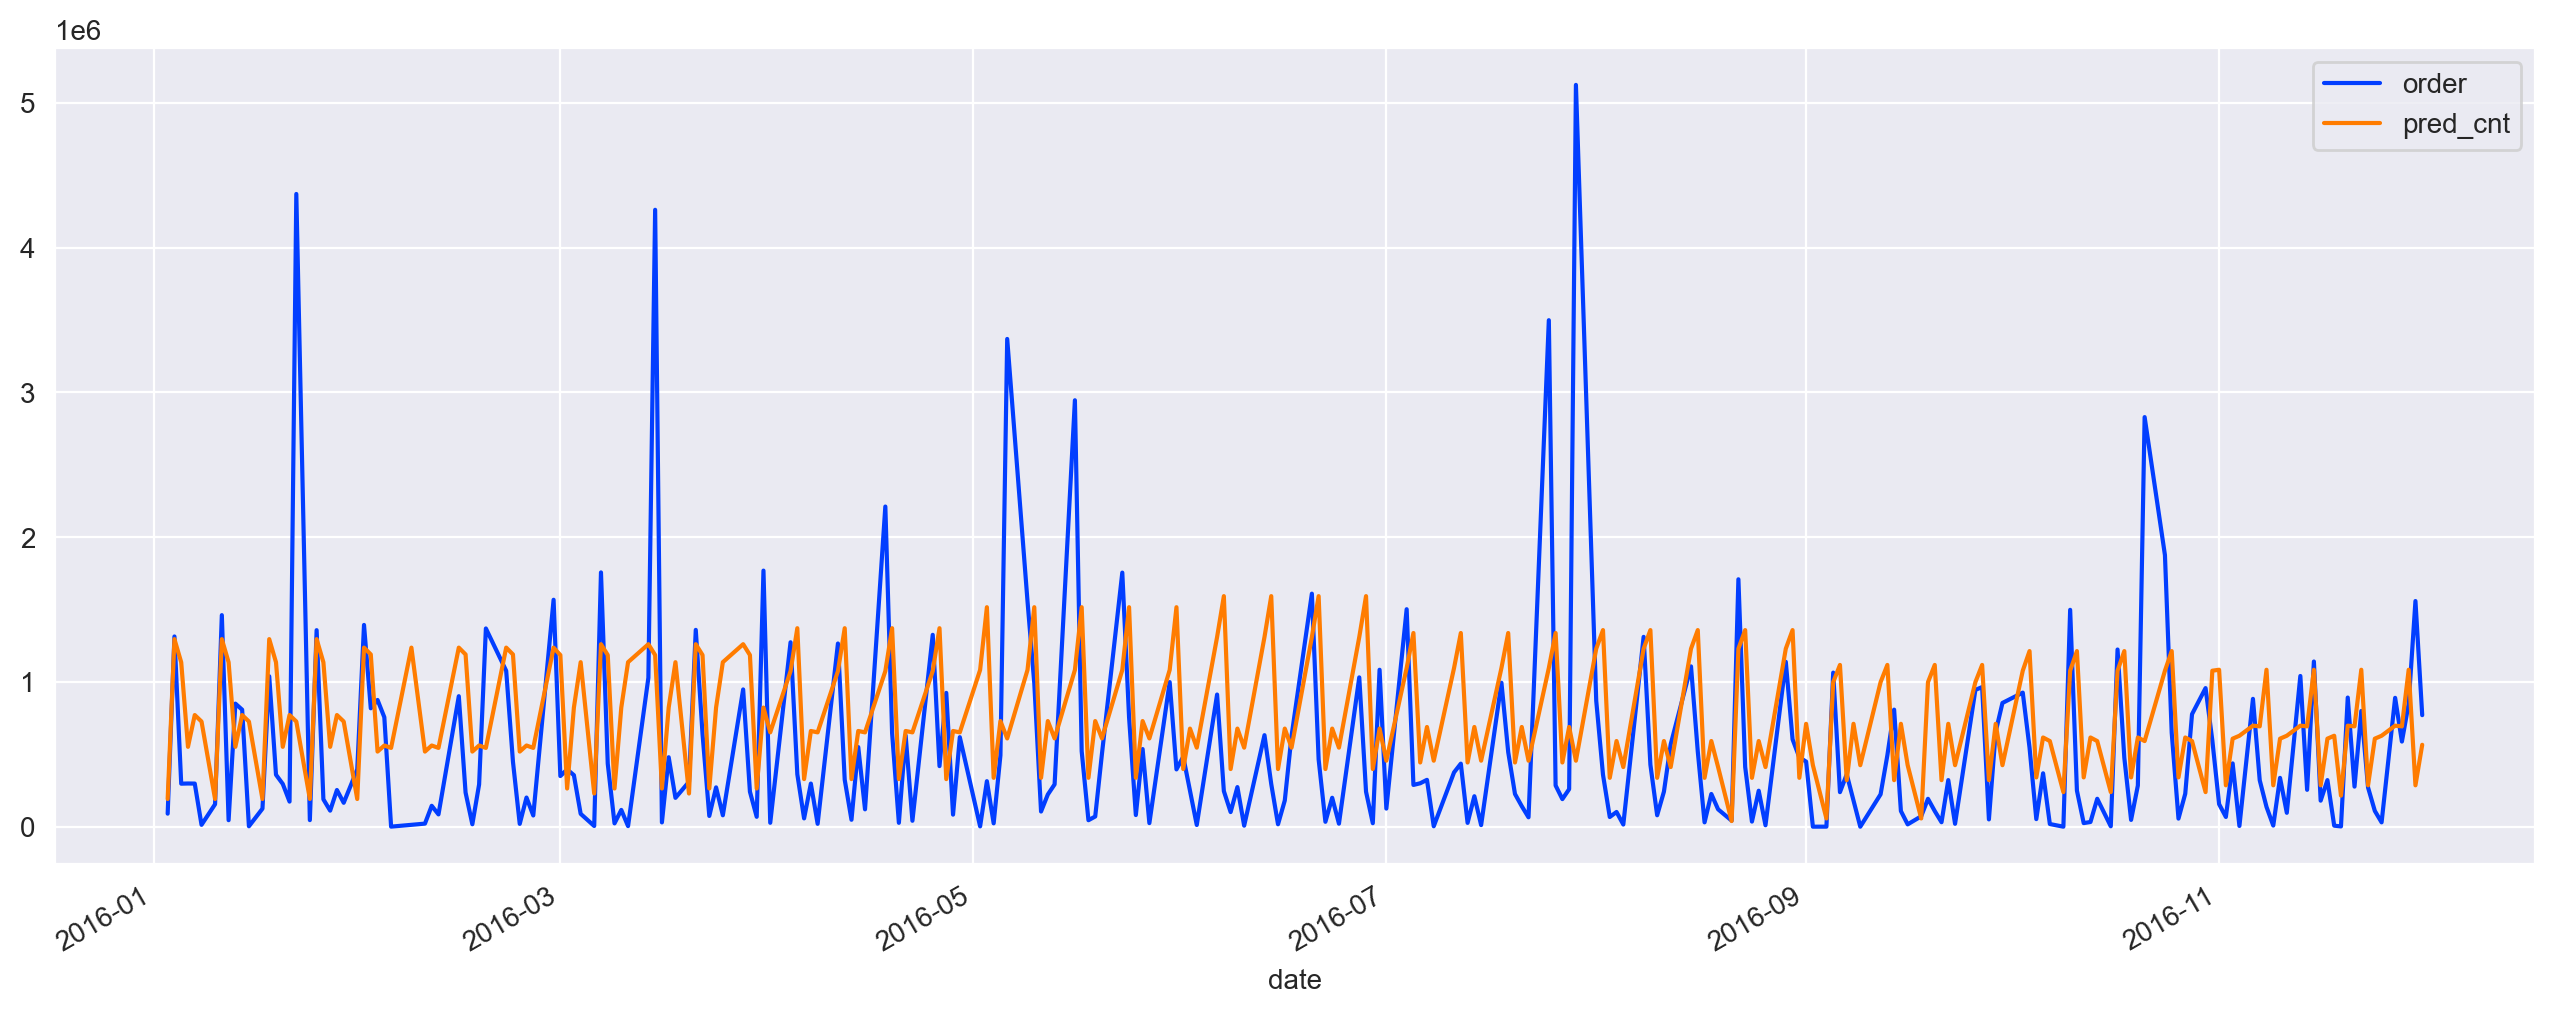

In [58]:
y_pred.query("warehouse == 'Whse_S'").plot(figsize=(16,6))

<Axes: xlabel='date'>

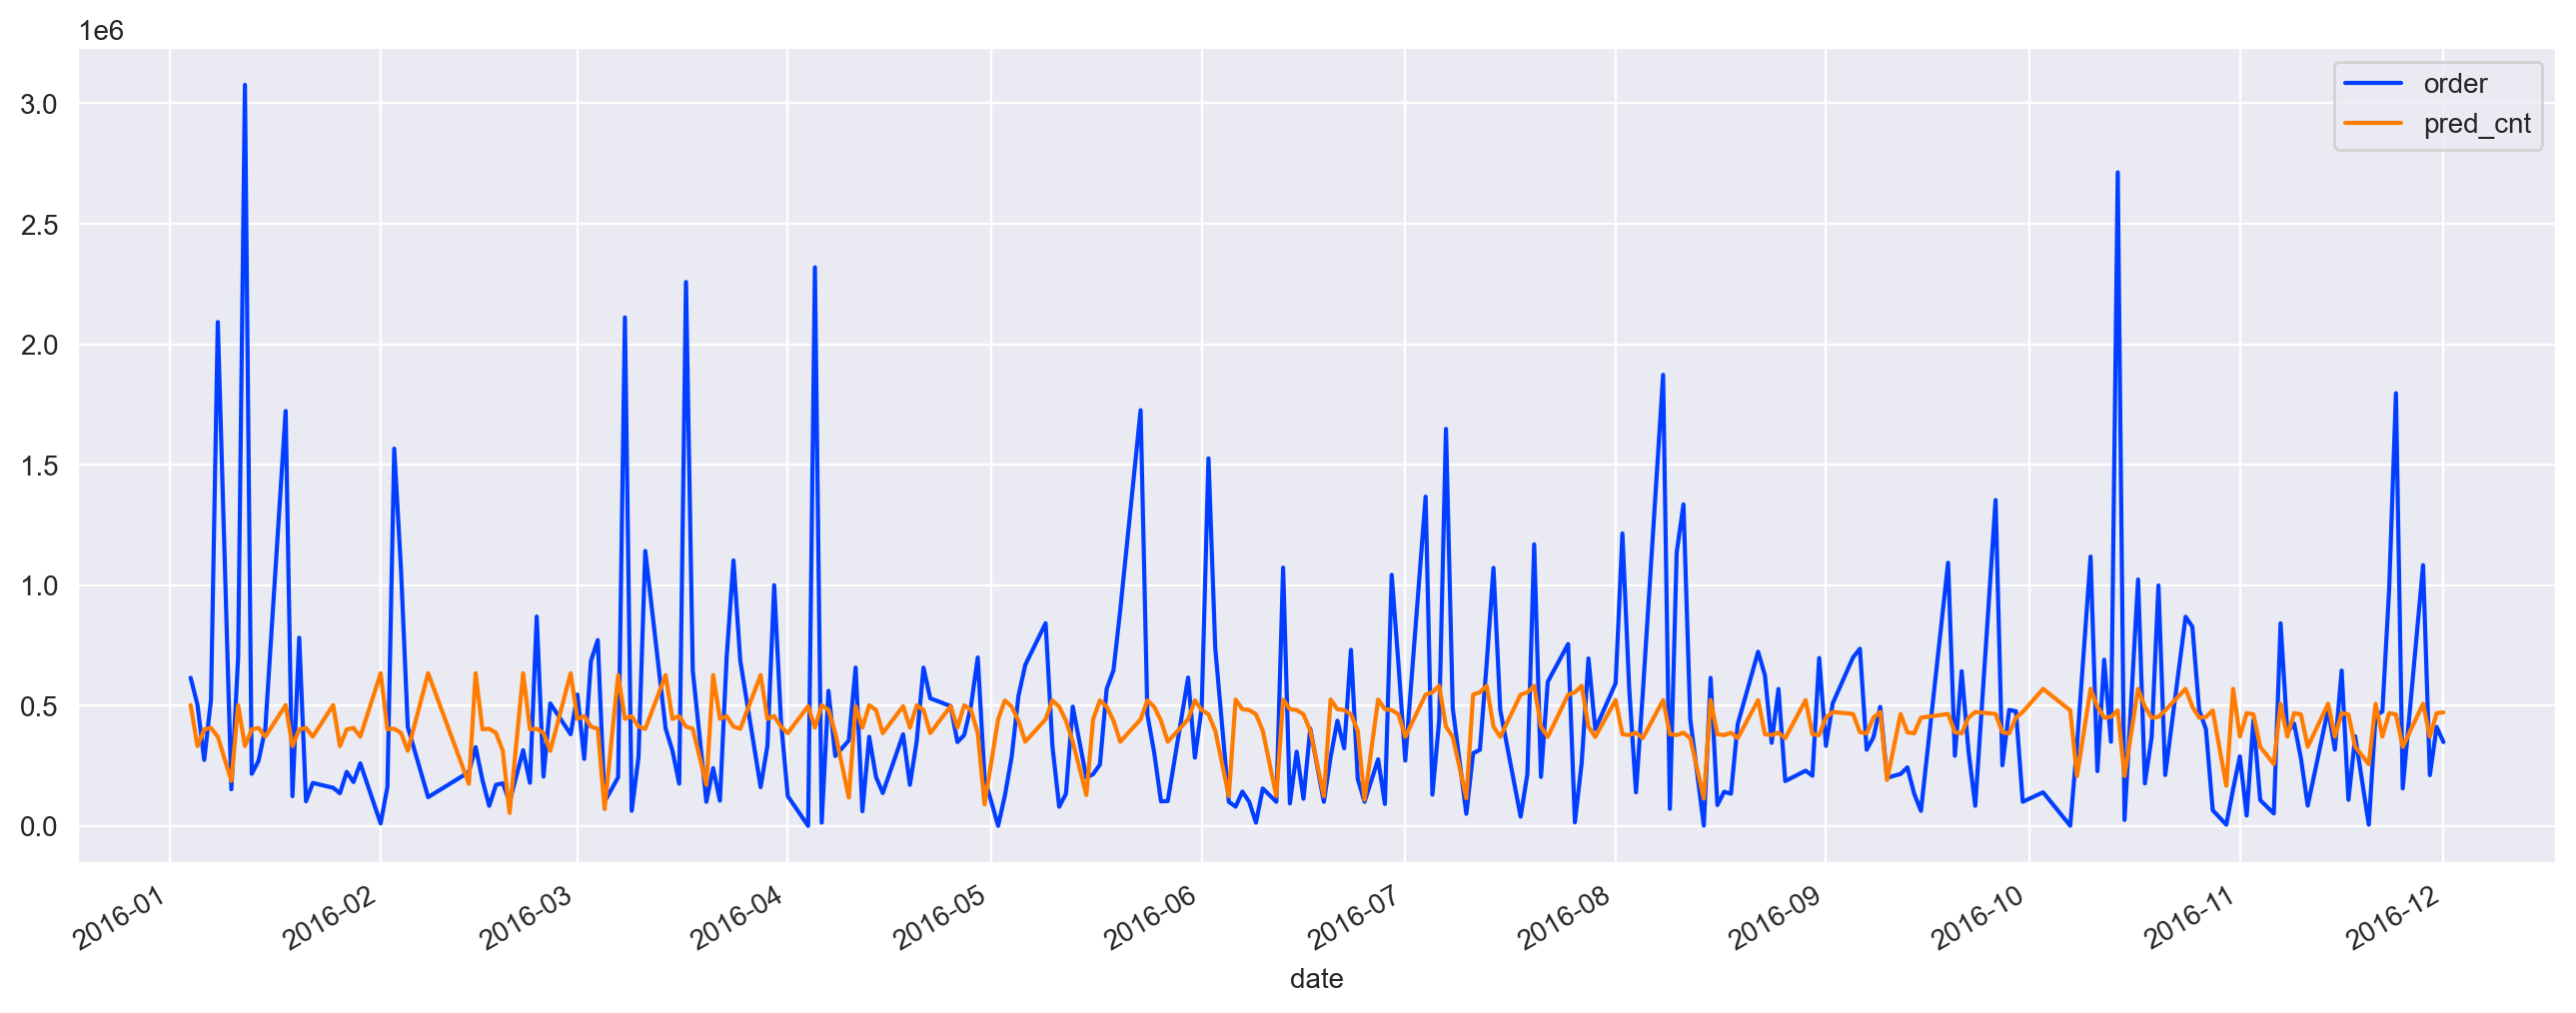

In [59]:
y_pred.query("warehouse == 'Whse_C'").plot(figsize=(16,6))

<Axes: xlabel='date'>

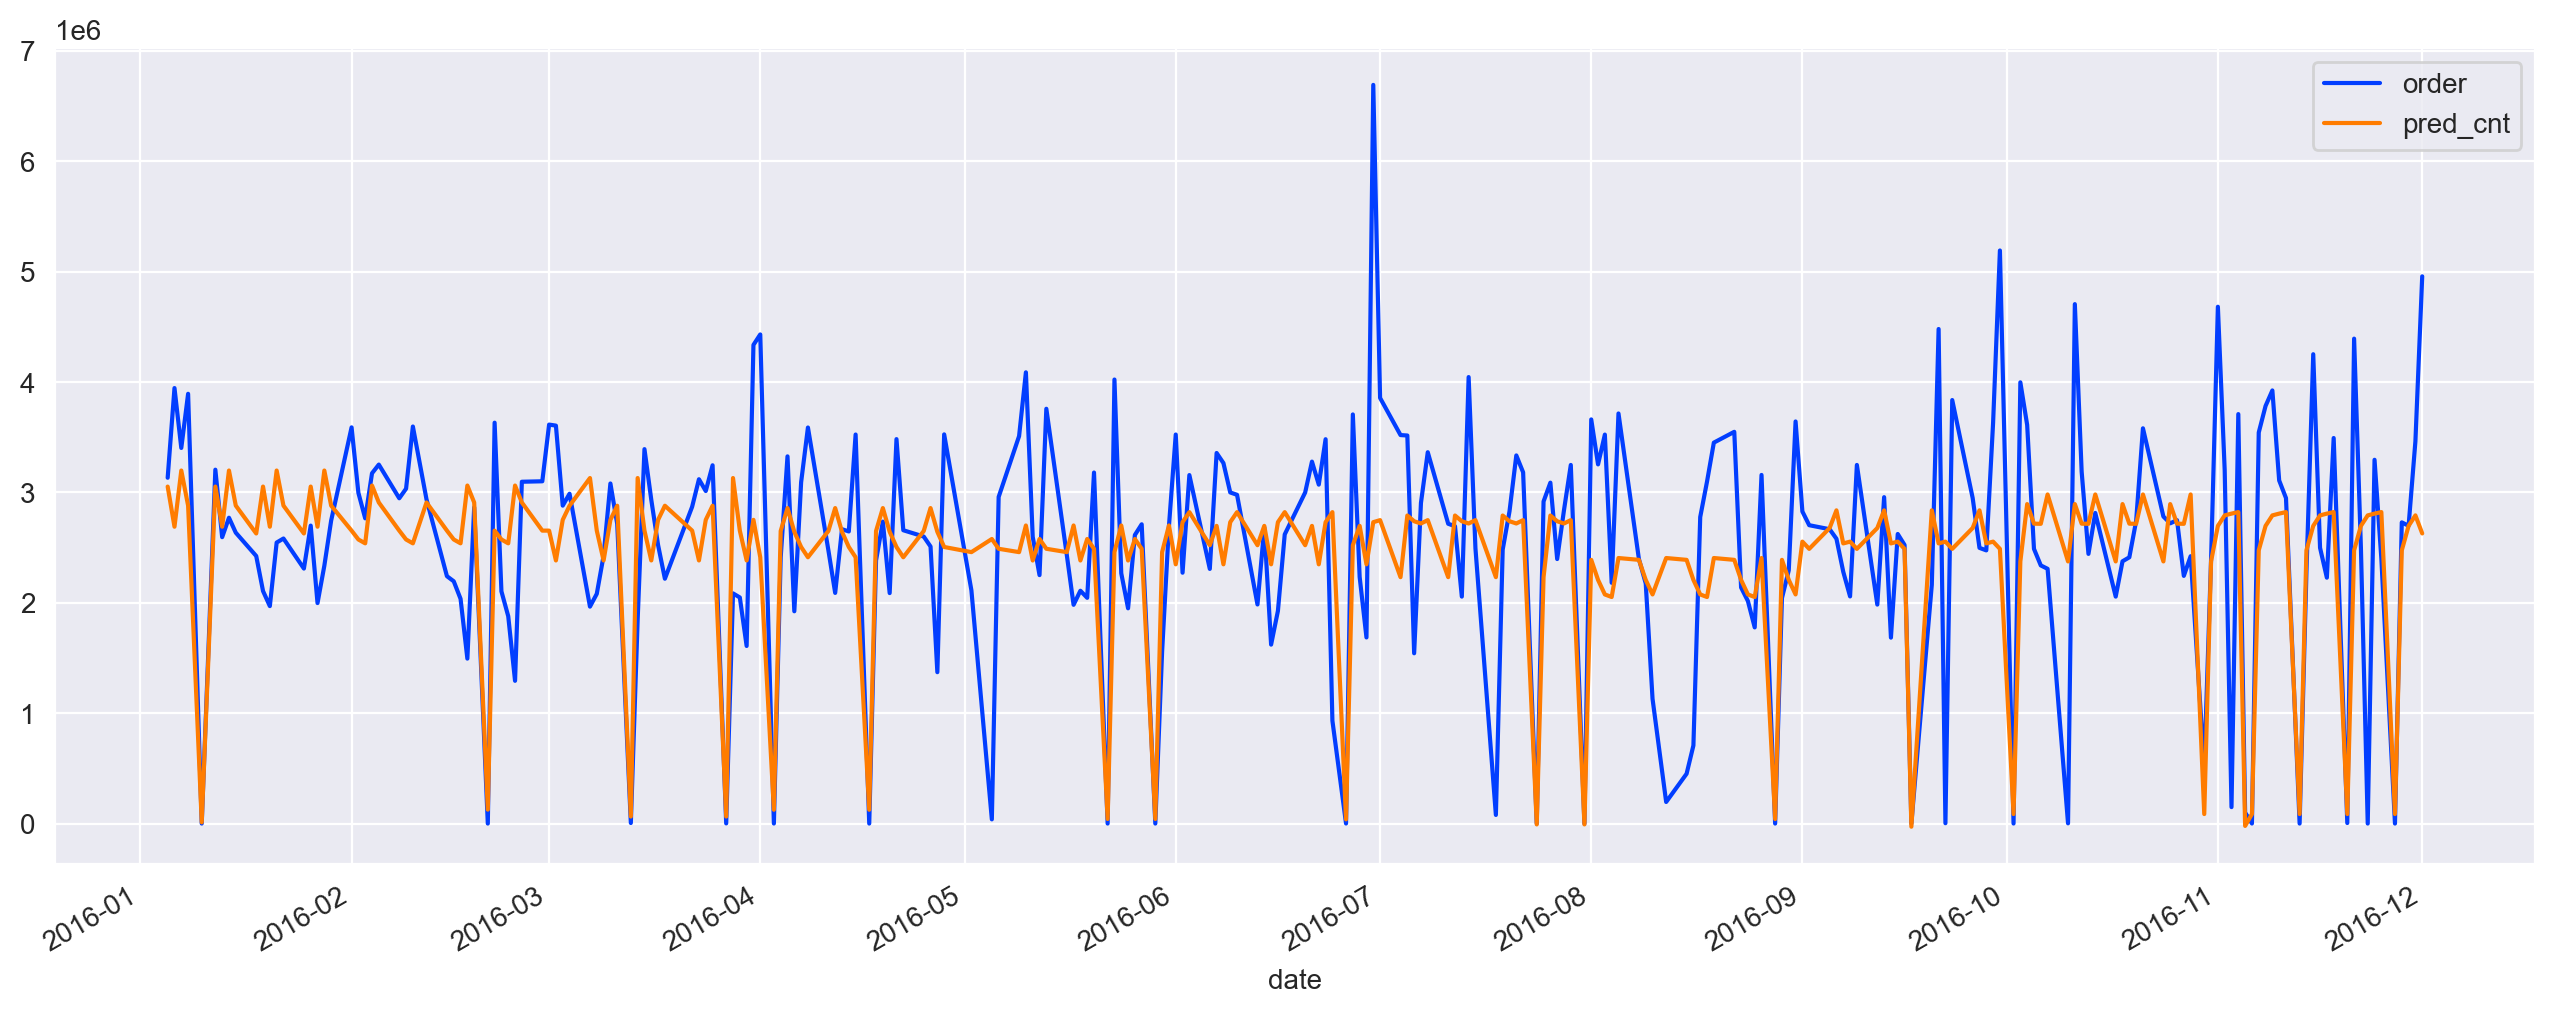

In [60]:
y_pred.query("warehouse == 'Whse_J'").plot(figsize=(16,6))

In [27]:
df

,warehouse,date_month,order,month
0,Whse_A,2012-01-01,1920092,1
1,Whse_A,2012-02-01,2543423,2
2,Whse_A,2012-03-01,2343061,3
3,Whse_A,2012-04-01,1947054,4
4,Whse_A,2012-05-01,2681003,5
...,...,...,...,...
235,Whse_S,2016-08-01,10725489,8
236,Whse_S,2016-09-01,8160732,9
237,Whse_S,2016-10-01,13912789,10
238,Whse_S,2016-11-01,11660963,11


0       1
1       2
2       3
3       4
4       5
       ..
235     8
236     9
237    10
238    11
239    12
Name: date_month, Length: 240, dtype: int64

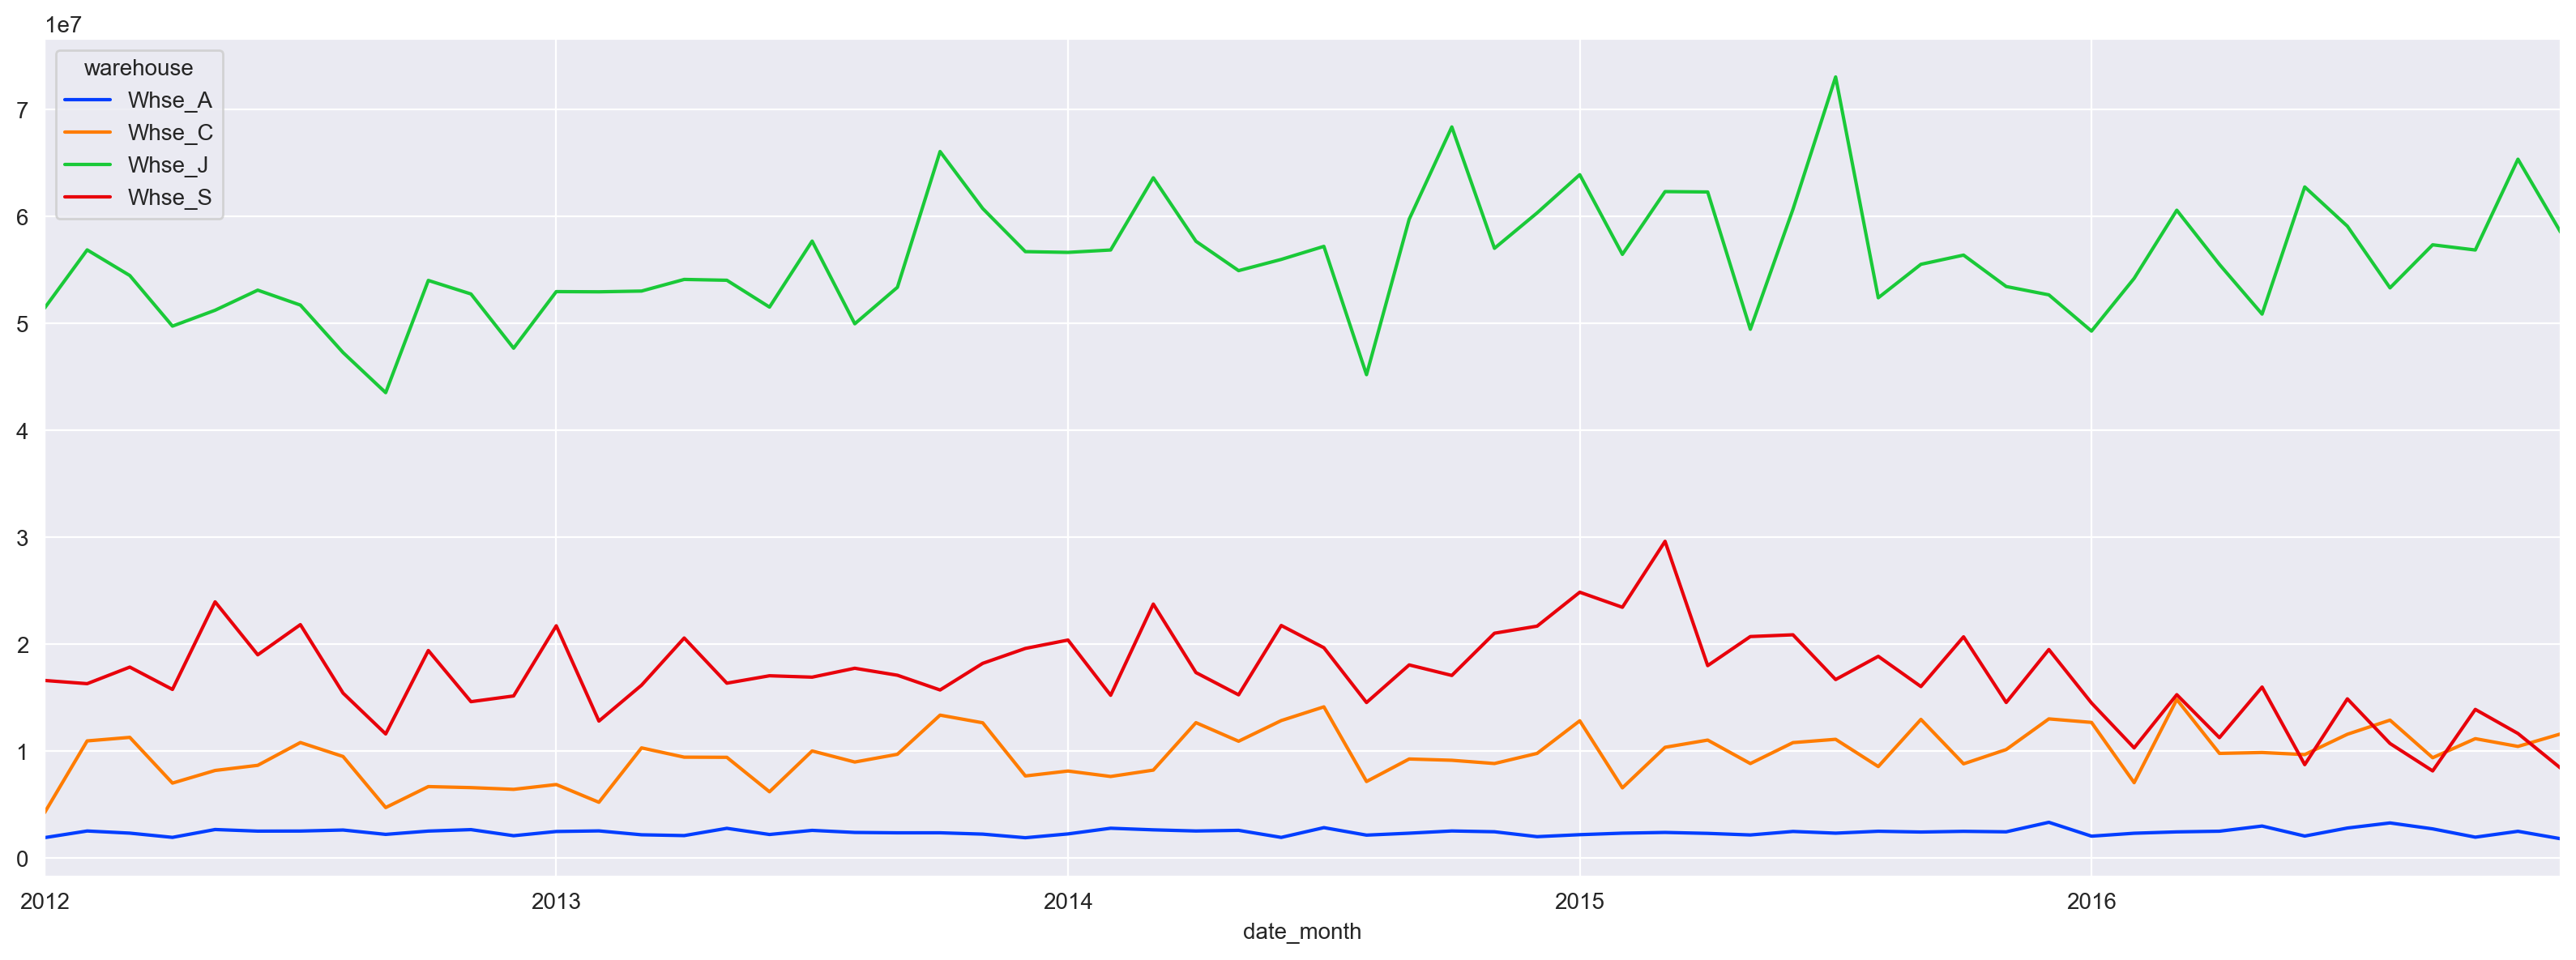

In [24]:
# 센터별 주문수 체크
df.groupby(['date_month', 'warehouse']).order.sum().unstack().plot(figsize=(16,6))
plt.tight_layout()

In [ ]:
df

In [182]:
df['day'] = df['date'].dt.day_name()

/var/folders/67/0vm0jqj17wq8dnq6yst_l3mm0000gn/T/ipykernel_49782/2231870482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['date'].dt.day_name()


In [ ]:
df.groupby()

In [158]:
# daily to monthly or
# sum after daily base predict 

In [161]:
df = df.groupby(['warehouse', 'date'])['order'].sum().reset_index()

In [183]:
df

,prd_code,warehouse,category,date,order,date_month,day
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012-07-01,Friday
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012-01-01,Thursday
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012-02-01,Friday
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012-02-01,Thursday
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012-03-01,Friday
...,...,...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000,2016-04-01,Wednesday
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1,2016-04-01,Wednesday
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500,2016-04-01,Thursday
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50,2016-10-01,Friday


In [ ]:
sns.swarmplot(data=df, x="day", y='order', hue="day")

KeyboardInterrupt: 

<Axes: xlabel='day'>

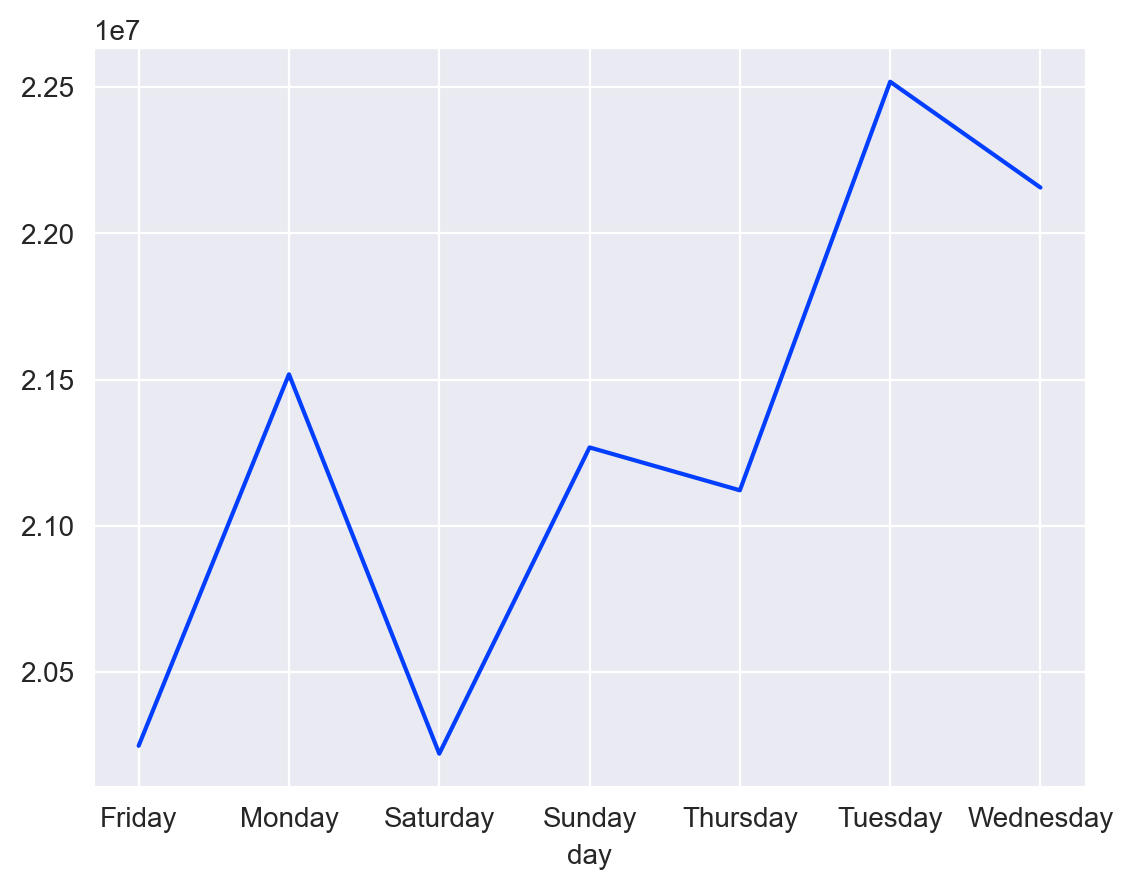

In [171]:
df.groupby(['day'])['order'].mean().plot()

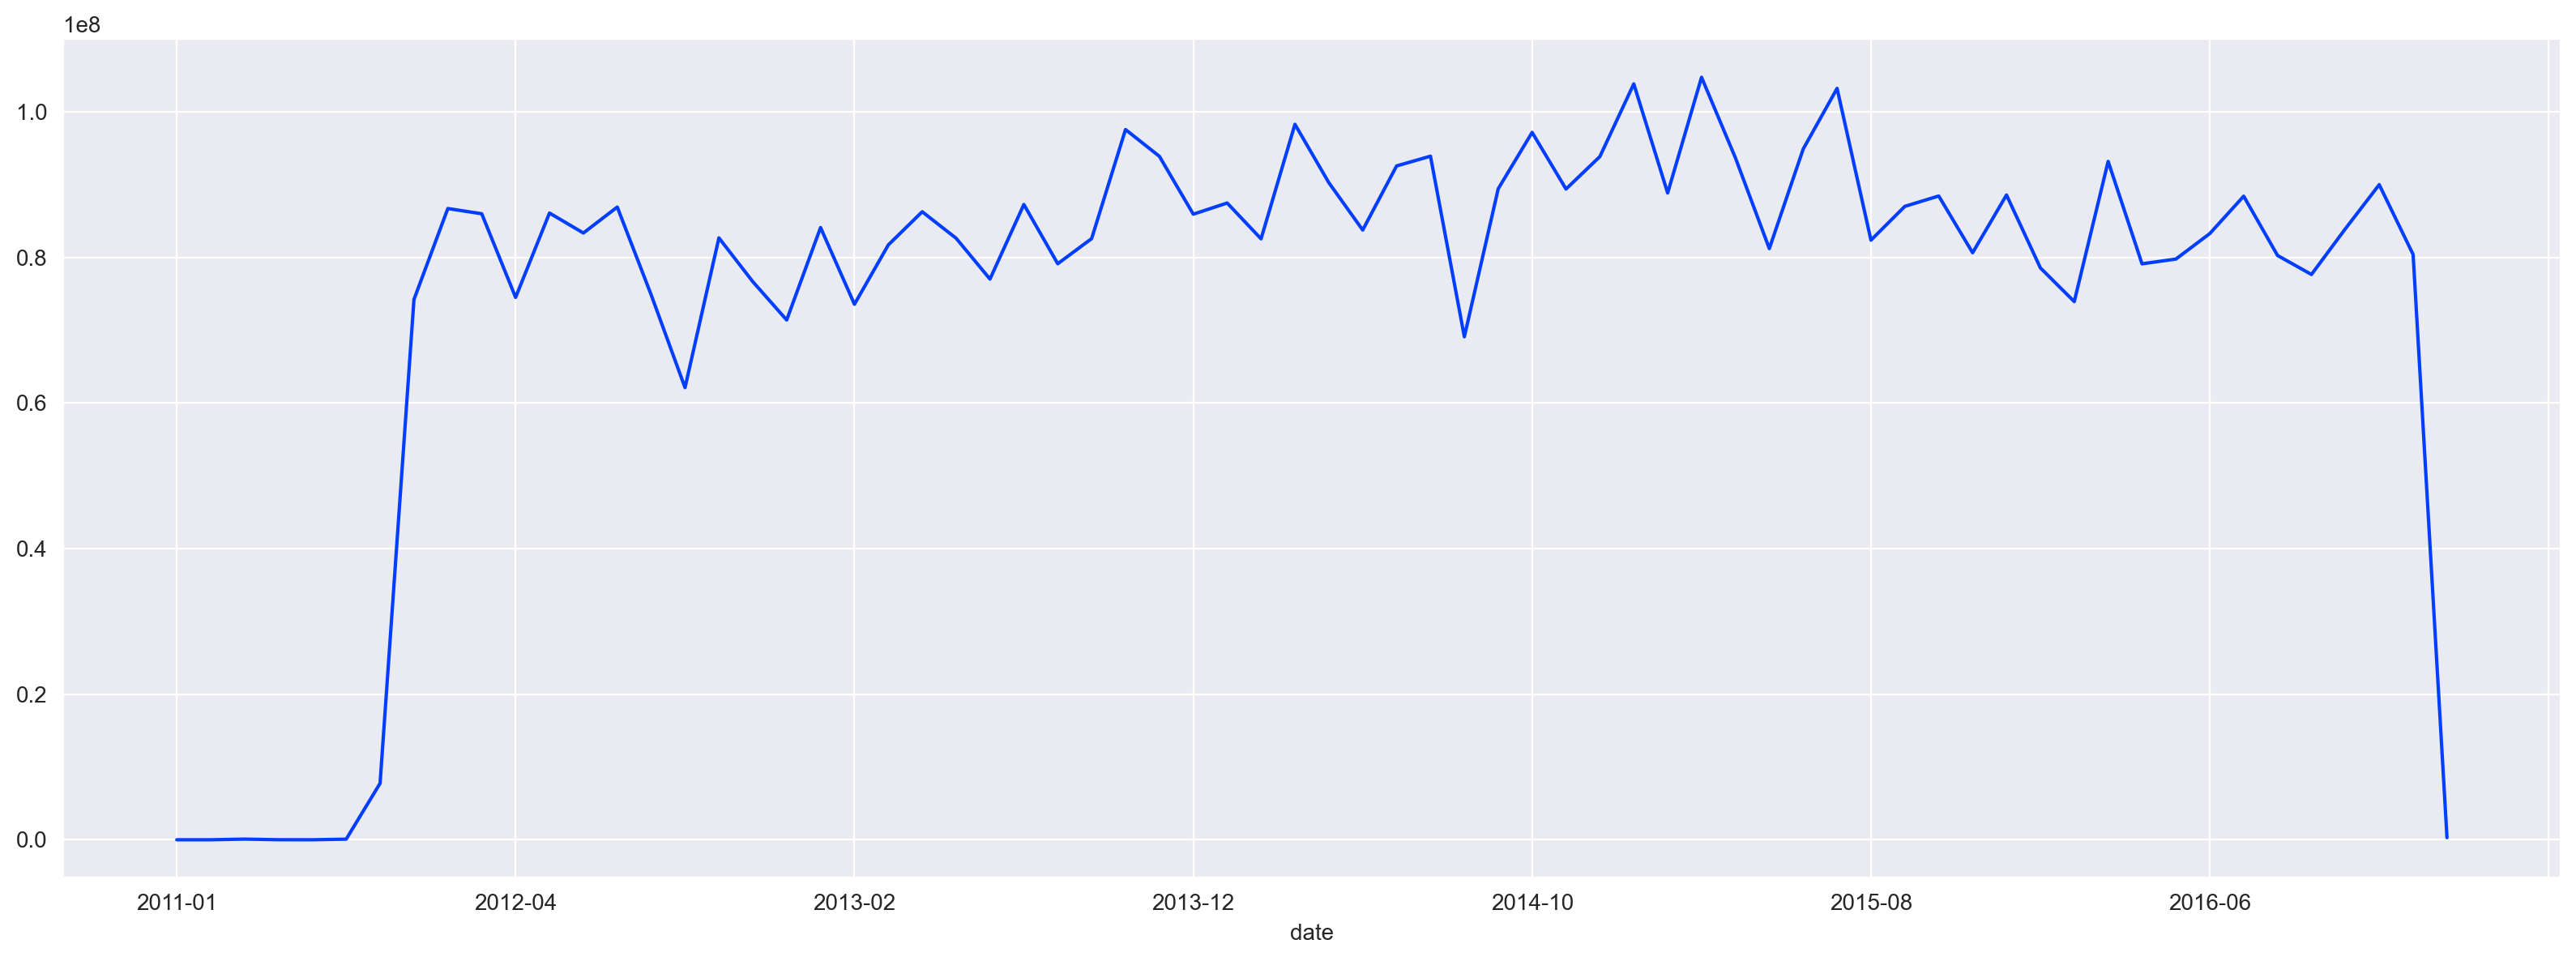

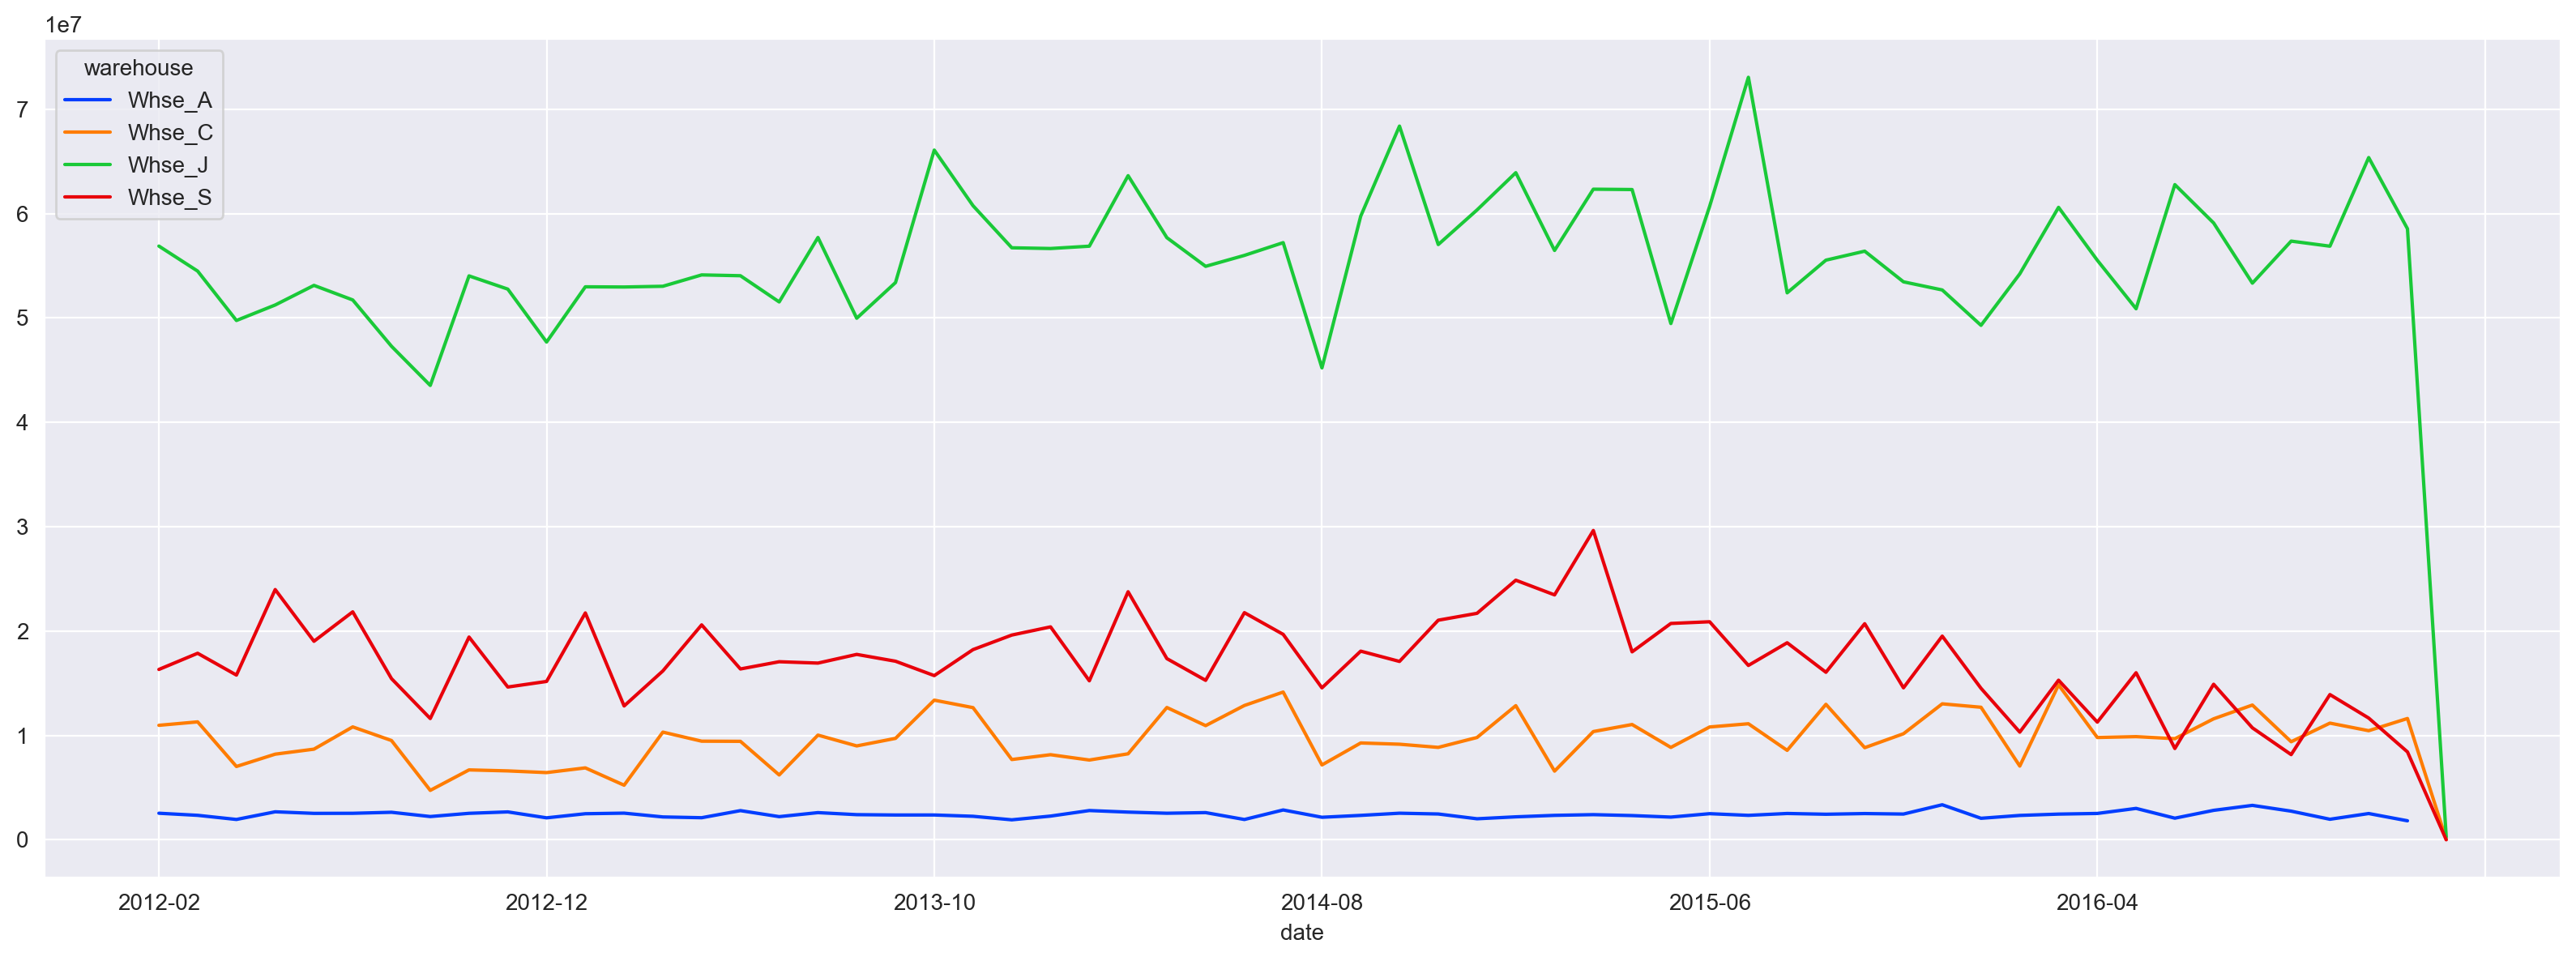

In [102]:
df.groupby(['date', 'warehouse']).order.sum().unstack().plot(figsize=(16,6))
plt.tight_layout()

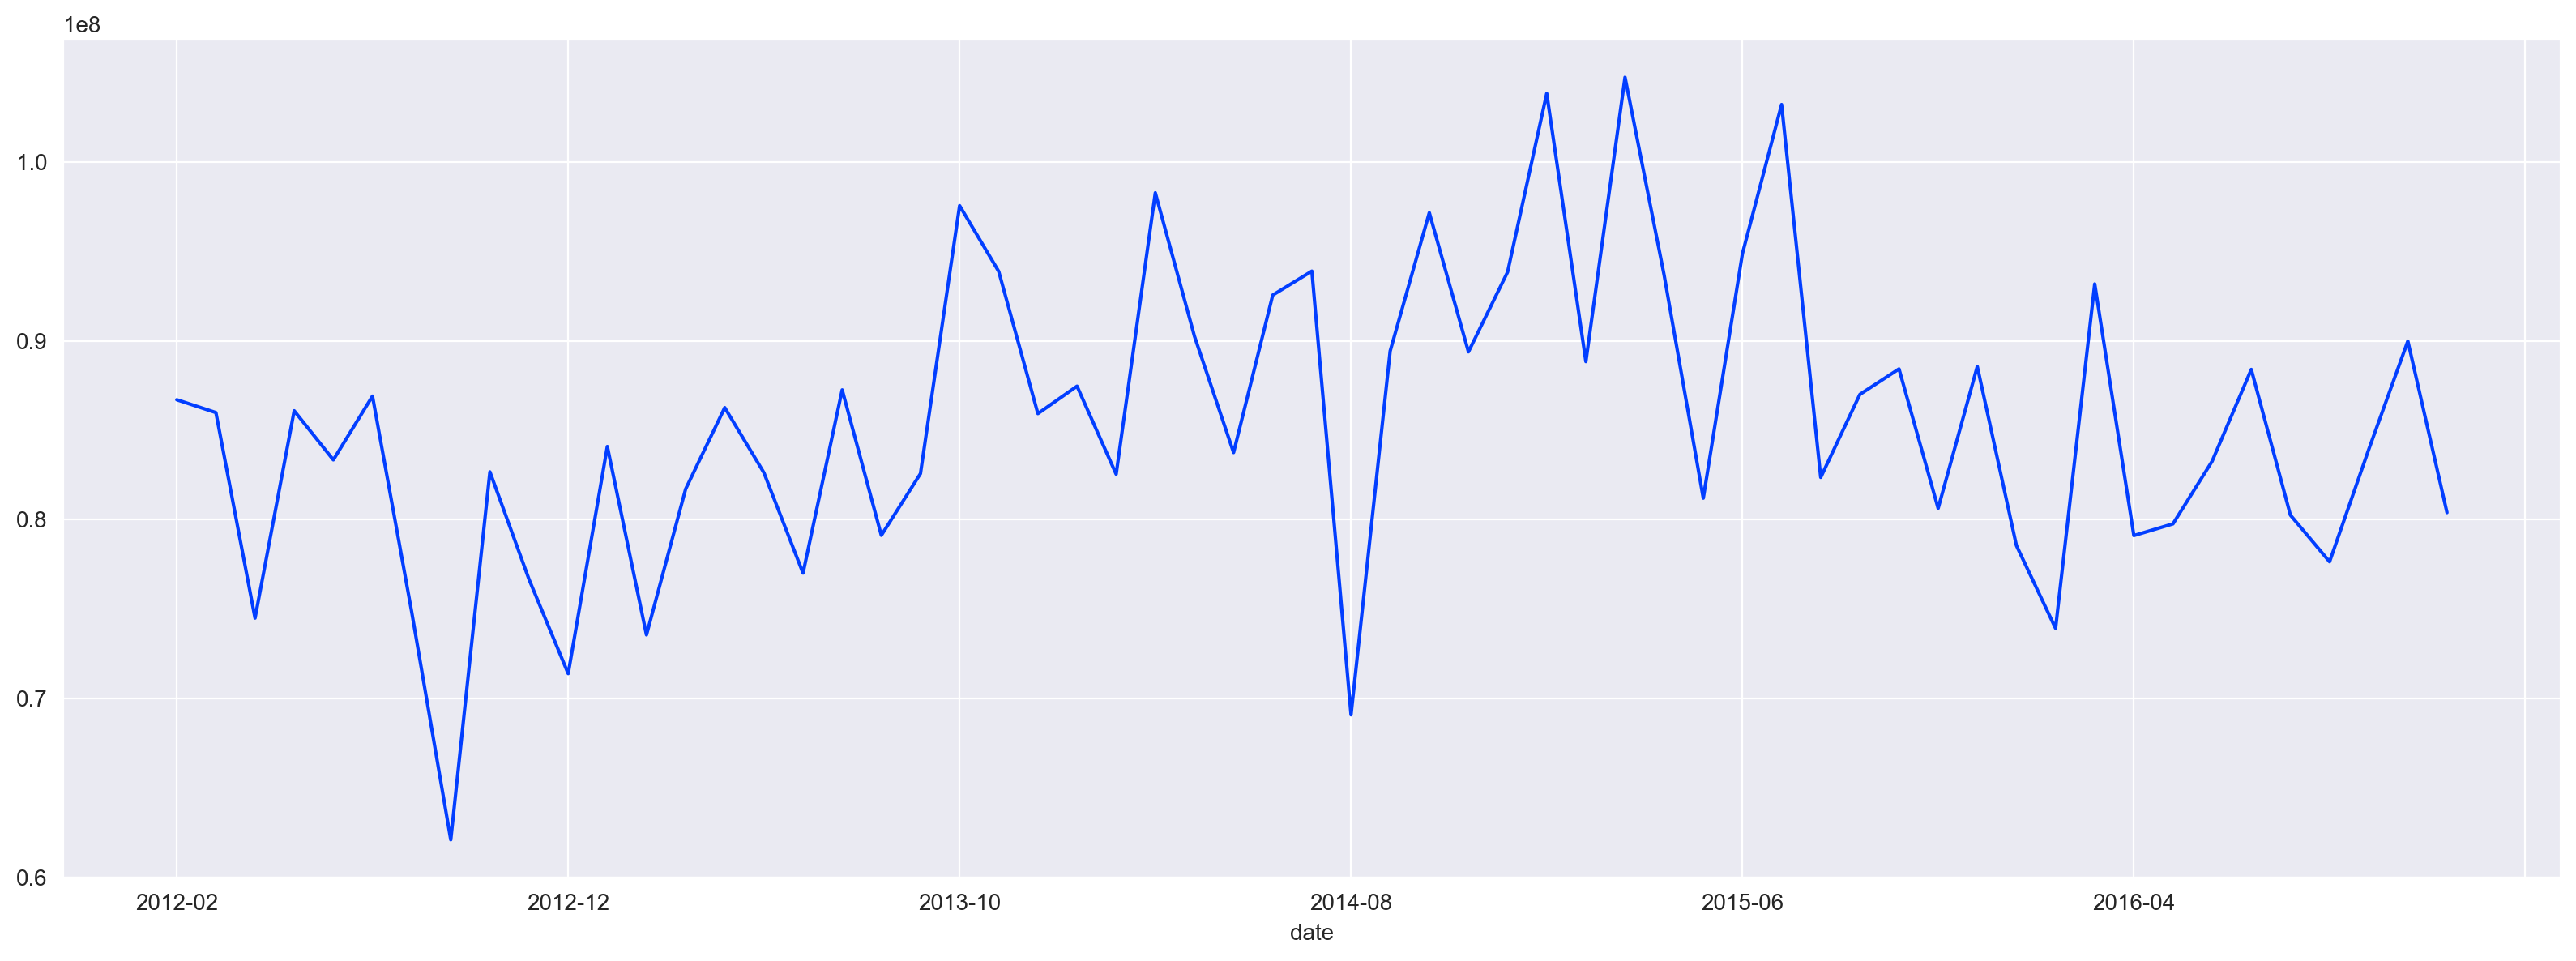

In [118]:
df.groupby(['date']).order.sum().plot(figsize=(16,6))
plt.tight_layout()

In [ ]:
# 12년 이전 는 수치가 너무 적어서 제외
# 데이터수집을 12년부터 시작한듯

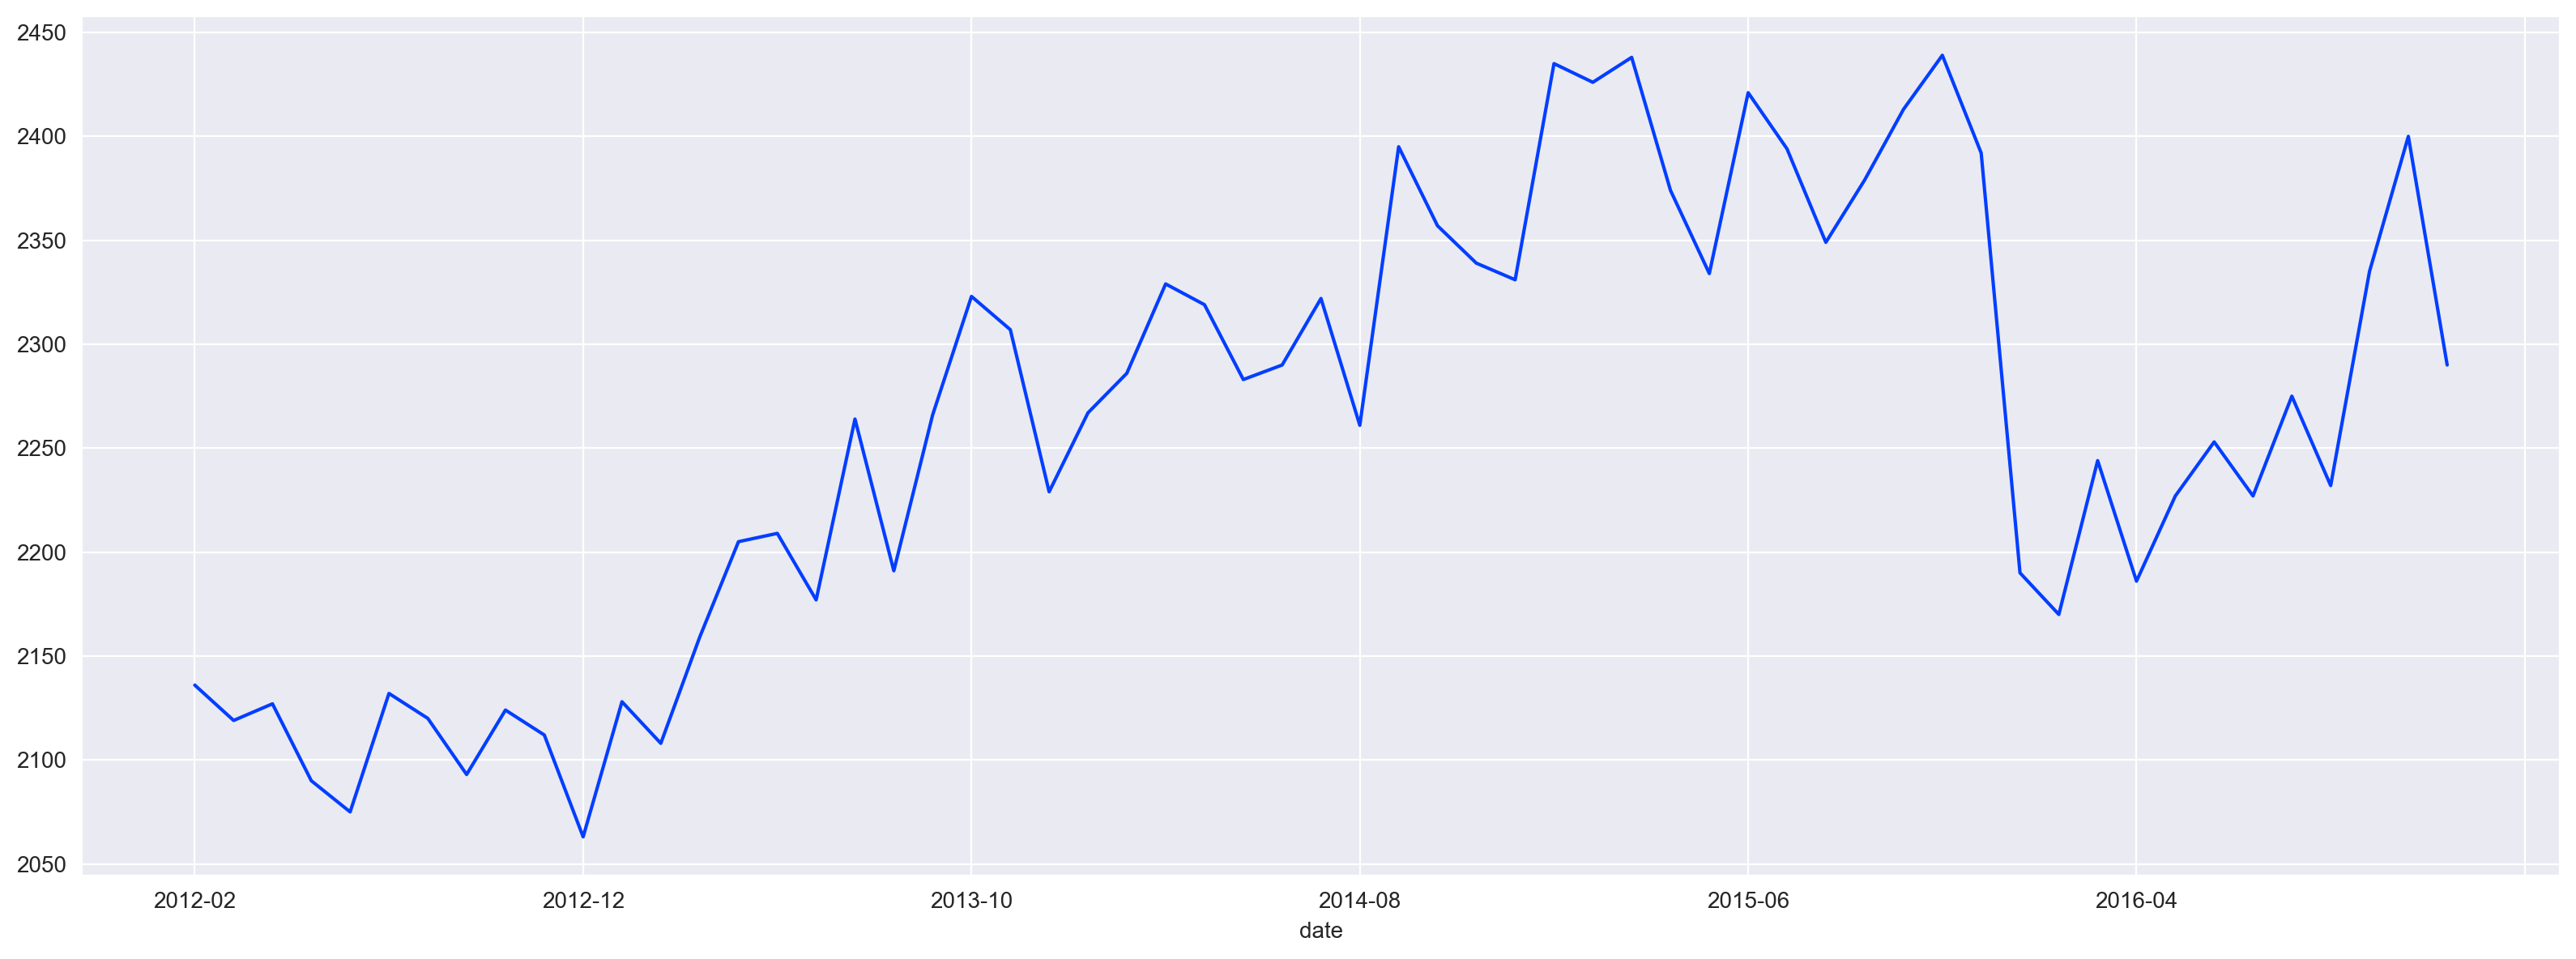

In [120]:
df.groupby('date').order.size().plot(figsize=(16,6))

plt.tight_layout()

In [78]:
print(len(df.prd_code.value_counts())) # 2160개의 상품
print(len(df.warehouse.value_counts())) # 4개 창고
print(len(df.category.value_counts())) # 33개 카테고리

2160
4
33


In [81]:
df.groupby(['warehouse']).order.sum()

warehouse
Whse_A     151152297
Whse_C     583458308
Whse_J    3353861057
Whse_S    1036126159
Name: order, dtype: int64

In [82]:
df.groupby(['category']).order.sum()

category
Category_001       1742936
Category_002           624
Category_003        390697
Category_004         98277
Category_005     199021605
Category_006     403614499
Category_007     128208687
Category_008         17545
Category_009       3695567
Category_010         21836
Category_011       2872254
Category_012         68278
Category_013        305830
Category_014           100
Category_015        823397
Category_016         16850
Category_017         47883
Category_018         45737
Category_019    4235512135
Category_020       2367472
Category_021       4414879
Category_022        599506
Category_023       3326785
Category_024       1045596
Category_025        486000
Category_026        280060
Category_027            80
Category_028      48213229
Category_029         23020
Category_030      40373955
Category_031         12998
Category_032       4459504
Category_033      42490000
Name: order, dtype: int64

In [83]:
df.groupby(['warehouse']).order.describe() # stats by center

,count,mean,std,min,25%,50%,75%,max
warehouse,,,,,,,,
Whse_A,147179.0,1026.996358,4340.340863,0.0,3.0,68.0,600.0,396200.0
Whse_C,42237.0,13813.914530,59429.217488,0.0,100.0,1000.0,6000.0,3000000.0
Whse_J,760892.0,4407.801708,21185.397316,0.0,25.0,300.0,2000.0,3000000.0
Whse_S,87798.0,11801.250131,65018.567415,0.0,30.0,500.0,4000.0,4000000.0


<Axes: >

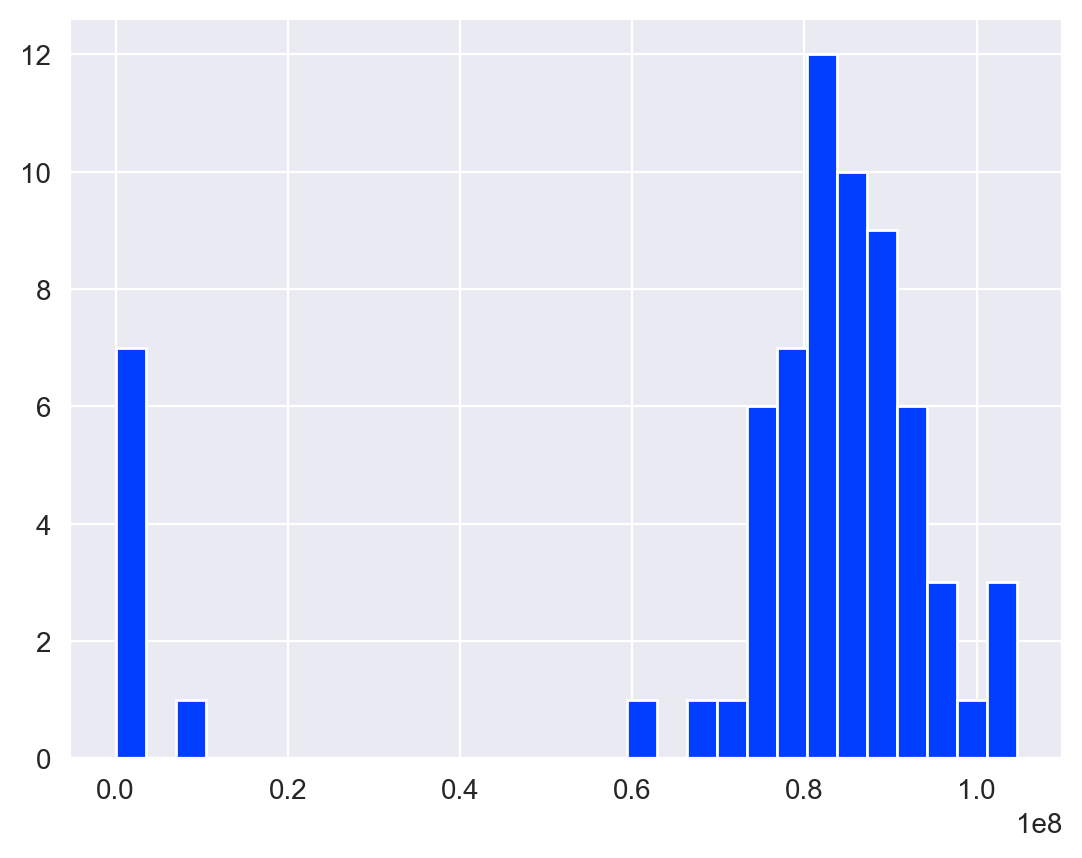

In [88]:
df_whse_a = df.groupby(['date']).order.sum()

df_whse_a.hist(bins=30)

In [84]:
df.query("warehouse == 'Whse_A'")

,prd_code,warehouse,category,date,order
34593,Product_0905,Whse_A,Category_023,2012-03,50
41029,Product_0097,Whse_A,Category_019,2012-01,6000
41030,Product_1496,Whse_A,Category_019,2012-03,5000
41031,Product_0097,Whse_A,Category_019,2012-04,6000
41032,Product_0097,Whse_A,Category_019,2012-09,3900
...,...,...,...,...,...
995797,Product_1822,Whse_A,Category_018,2016-03,2
995798,Product_1470,Whse_A,Category_019,2016-05,100
995799,Product_0599,Whse_A,Category_017,2016-09,12
995800,Product_0599,Whse_A,Category_017,2016-10,10


In [ ]:
# 그룹 구분을 센터와 카테고리로만

In [46]:
df1 = df.groupby(['date', 'warehouse'])['order'].sum().reset_index()

In [47]:
df1

,date,warehouse,order
0,2011-01-08,Whse_A,2
1,2011-05-31,Whse_A,108
2,2011-06-24,Whse_S,92000
3,2011-09-02,Whse_C,1250
4,2011-09-27,Whse_C,28
...,...,...,...
5900,2017-01-04,Whse_C,29000
5901,2017-01-04,Whse_J,250
5902,2017-01-05,Whse_J,83929
5903,2017-01-06,Whse_J,175140
